## Storage and Databases

### Introduction

https://www.youtube.com/watch?v=7QSyJLYUXQE

Lesson Objectives
Upon completion of this lesson, you will be able to:

Deploy highly available RDS databases using CloudFormation.
Configure secure S3 buckets using CloudFormation.
Preview changes to your CloudFormation stacks using change sets.
Automate your infrastructure workflows using parameterized scripts.

## RDS Resources

RDS (Relational Database Service) is the AWS-managed relational database solution. It's relational because it supports databases like MySQL, PostgreSQL, Oracle, just to name a few. And it's managed because it takes care of all the hard work that comes with maintaining a database. These are the main examples, just to name a few:

Automated backups
Encryption
Multi-AZ deployments
Software updates
Monitoring
Scaling

You still have the power to configure the aforementioned features, but AWS will take care of them for you. This means you can focus on building your applications instead of worrying about the infrastructure.

And yes, you can also manage your RDS databases using CloudFormation. Let's see how.

## Adding RDS Resources to Our Template

https://www.youtube.com/watch?v=30zzyK7ZwMY

AWS::RDS::DBInstance syntax
This is how we add an RDS instance to our template:

In [ ]:
Resources:
  MyDBInstance:
    Type: 'AWS::RDS::DBInstance'
    Properties:
      AllocatedStorage: Integer
      AutoMinorVersionUpgrade: Boolean
      BackupRetentionPeriod: Integer
      DBInstanceClass: String
      DBInstanceIdentifier: String
      DBName: String
      VPCSecurityGroups:
        - String
      DBParameterGroupName: String
      DBSubnetGroupName: String
      Engine: String
      EngineVersion: String
      MasterUsername: String
      MasterUserPassword: String
      MultiAZ: Boolean

Let's explain those properties a little more:

Engine: The name of the database engine to use for the instance. Some available values are postgres, mysql, oracle-ee, sqlserver-ee. You can also use the Aurora offering exclusive to AWS: aurora, aurora-mysql, aurora-postgresql. Take a look at the resource reference in the additional resources for a list of available engines.
EngineVersion: The version of the database engine to use for the instance. Depends on the engine you choose.
AllocatedStorage: The amount of storage (GiB) to allocate to the DB instance.
AutoMinorVersionUpgrade: Whether automatic minor version upgrades are applied to the DB instance during the maintenance window.
BackupRetentionPeriod: The number of days to retain automated backups of the DB instance. Can be disabled by using 0.
DBInstanceClass: The DB instance class to use for the instance. Some available values are db.t3.micro, db.m4.large and so forth. Take a look at the additional resources for a list of available instance classes.
DBInstanceIdentifier: A unique identifier for the DB instance.
DBName: The name of the database to create on the instance.
VPCSecurityGroups: A list of regular VPC security groups to associate with the DB instance. This is how you grant network access to this resource. Remember the golden rule: use least privilege access to your databases!
MultiAZ: Whether to use a multiple availability zone deployment.
MasterUsername: The name of the master user for the instance.
MasterPassword: The password of the master user for the instance.
Passing a password for the master user in the CloudFormation template might be a bit surprising. And yes, this is not a best practice. You can at least pass those values as a runtime parameter, thus avoiding to include it into your template.

But there is another method that allows you to store this information in a security service provided by AWS, called Secrets Manager. We will not demonstrate that integration in this lesson, yet it would be good for you to take a look at it.

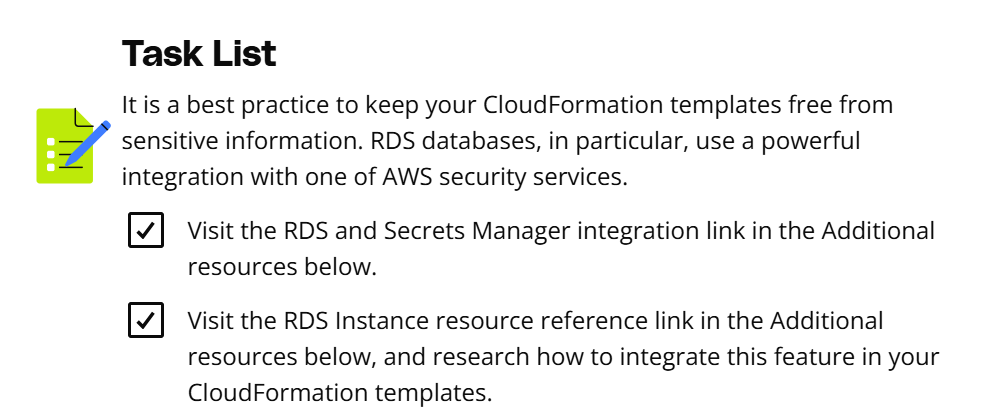

Let's go into details regarding two parameters, as they refer to resources that are also new to us.

DBSubnetGroupName A DB Subnet Group is the way you specify the subnets in which to create DB instances in Amazon RDS. In essence, it's a collection of subnet IDs from an existing VPC. Can be attached to many RDS instances.

DBParameterGroup A DB Parameter Group is how you specify parameter values to customize your DB instance in Amazon RDS. These are engine specific. Think of parameters like max_allowed_packet or group_concat_max_len. Can be attached to many RDS instances.

AWS::RDS::DBSubnetGroup syntax
This is how you create a DB subnet group in CloudFormation:

Resources:
  SubnetGroup:
    Type: 'AWS::RDS::DBSubnetGroup'
    Properties:
      DBSubnetGroupName: String
      DBSubnetGroupDescription: String
      SubnetIds:
        - !Ref SomeExistingSubnet1
        - !Ref SomeExistingSubnet2

DBSubnetGroupName: Required. The name of the subnet group.
DBSubnetGroupDescription: A description of the subnet group.
SubnetIds: A list of VPC subnet IDs for the subnet group. You must specify at least two subnets in different Availability Zones. It's a best practice to always place your database in private subnets, protected from internet access.

AWS::RDS::DBParameterGroup syntax
And this is how you create a DB parameter group in CloudFormation

Resources:
  SubnetGroup:
    Type: 'AWS::RDS::DBParameterGroup'
    Properties:
      DBClusterParameterGroupName: String
      Description: String
      Family: String
      Parameters:
        ParameterName: ParameterValue

DBClusterParameterGroupName: name for the DB parameter group.
Description: description for the DB parameter group.
Family: name of the DB parameter group family that this parameter group belongs to. Parameter group families determine which engine versions and database editions the parameter group can be applied to.
Parameters: list of parameters to set for the DB parameter group. The available parameters will depend on the family selected.

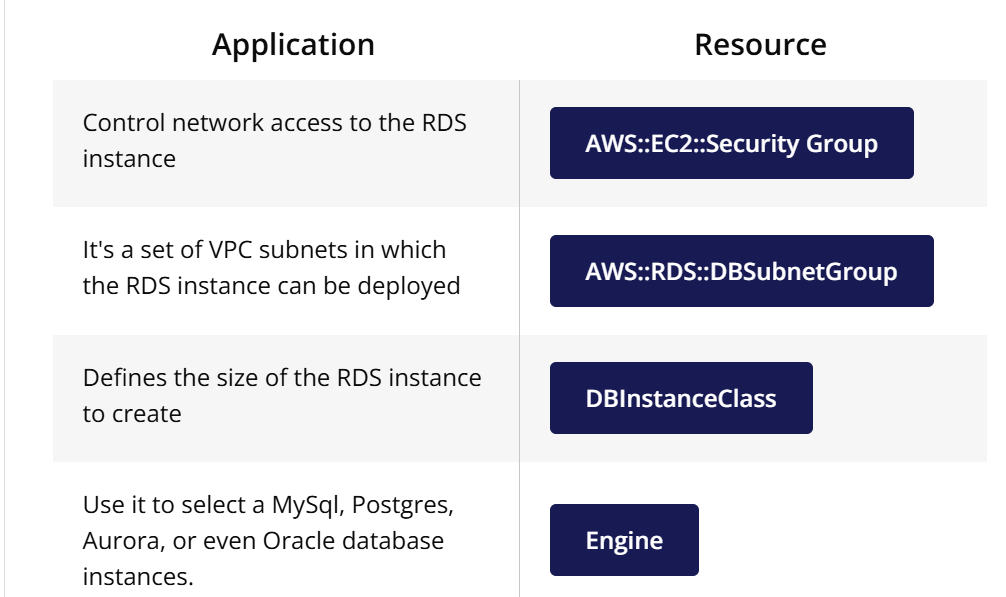

Example RDS resources
The following snippet implements the three previously mentioned resources in a CloudFormation template. We can use the networking resources from our previously created ourdemoinfra stack.

Parameters:

  EnvironmentName:
    Description: An environment name that will be prefixed to resource names
    Type: String

  ExampleName:
    Description: Name for this example resources
    Type: String
    Default: udacity-rds-example

  RdsMasterUsername:
    Type: String
    Description: Username for the RDS database

  RdsMasterPassword:
    Type: String
    Description: Password for the RDS database

Resources:

  SecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupName: !Ref ExampleName
      GroupDescription: DB Security group for RDS example
      VpcId:
        Fn::ImportValue:
          !Sub "${EnvironmentName}-VPCID"
      SecurityGroupIngress:
      - IpProtocol: tcp
        FromPort: 5432
        ToPort: 5432
        CidrIp: 10.10.0.0/24

  DBSubnetGroup:
    Type: AWS::RDS::DBSubnetGroup
    Properties:
      DBSubnetGroupName: !Ref ExampleName
      DBSubnetGroupDescription: DB subnet group for RDS example
      SubnetIds: !Split
      - ","
      - Fn::ImportValue:
          !Sub "${EnvironmentName}-PRIV-NETS"

  DBParameterGroup:
    Type: AWS::RDS::DBParameterGroup
    Properties:
      DBParameterGroupName: !Ref ExampleName
      Description: Custom parameter group for RDS example
      Family: postgres15
      Parameters:
        synchronous_commit: 'off'
        rds.force_ssl: 1

  DBInstance:
    Type: AWS::RDS::DBInstance
    DeletionPolicy: Snapshot
    Properties:
      AllocatedStorage: '20'
      AllowMajorVersionUpgrade: false
      AutoMinorVersionUpgrade: true      
      DBName: exampledb
      DBInstanceClass: db.t3.micro
      DBInstanceIdentifier: !Ref ExampleName
      VPCSecurityGroups:
        - !Ref SecurityGroup
      Engine: postgres
      EngineVersion: "15.2"
      DBSubnetGroupName: !Ref DBSubnetGroup
      DBParameterGroupName: !Ref DBParameterGroup
      MasterUsername: !Ref RdsMasterUsername
      MasterUserPassword: !Ref RdsMasterPassword

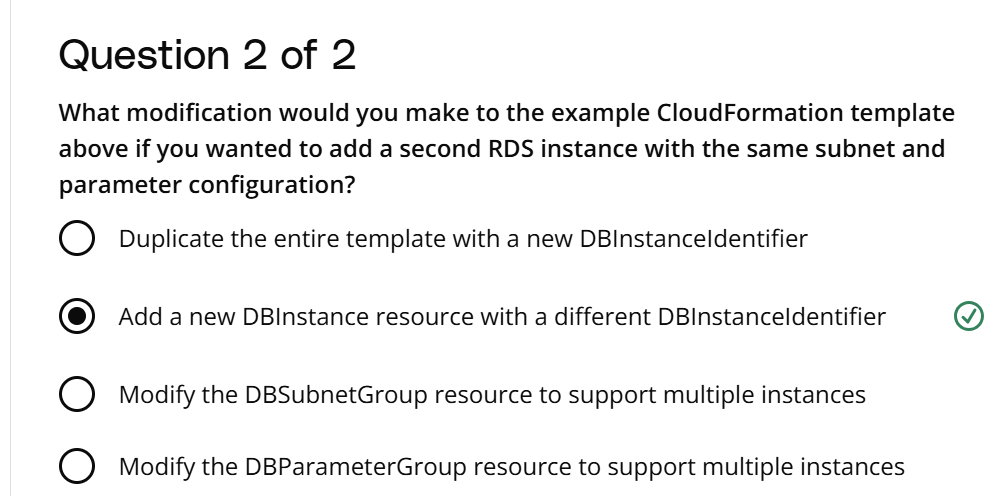

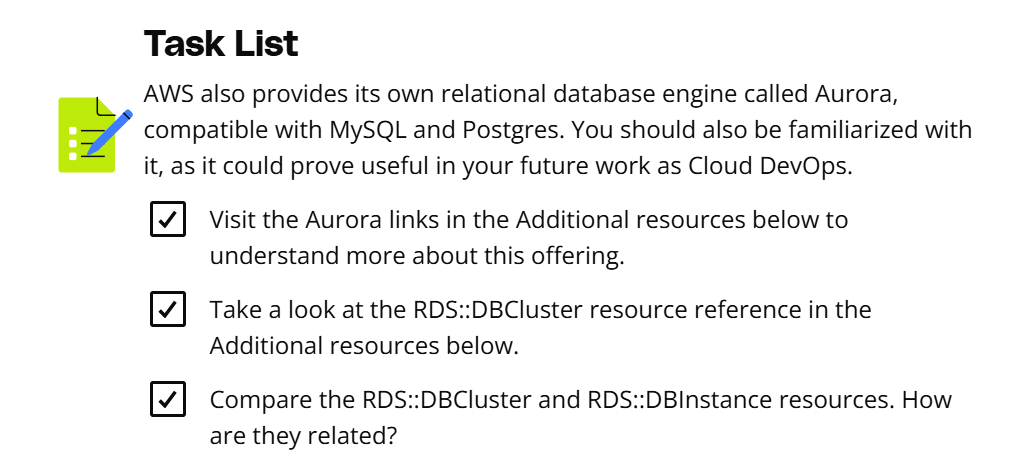

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Overview.DBInstance.html

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Concepts.DBInstanceClass.html

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/rds-secrets-manager.html


https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-rds-dbinstance.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-rds-dbparametergroup.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-rds-dbsubnetgroup.html

https://www.youtube.com/watch?v=FzxqIdIZ9wc&ab_channel=AmazonWebServices

https://docs.aws.amazon.com/AmazonRDS/latest/AuroraUserGuide/Aurora.CreateInstance.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-rds-dbcluster.html

## Preventing Deletion of RDS instances

There are a few CloudFormation properties that apply to all resources. We've already seen the DependsOn property before, now its time to introduce a new one: DeletionPolicy. With this property, you decide what happens to the actual AWS resource when its CloudFormation resource is deleted.

For stateful components like RDS instances, this can be critical to avoid data loss. There are three options for DeletionPolicy:

Delete: default for most resource types. When the CloudFormation stack is deleted, the RDS instance and its associated resources (such as DB snapshots and option groups) will be deleted as well.
Retain: when the CloudFormation stack is deleted, the RDS instance and its associated resources will not be deleted. This can be useful if you want to keep the database even if you are tearing down the rest of your infrastructure.
Snapshot: default for RDS instances. The RDS instance will be deleted when the CloudFormation stack is deleted, but a final DB snapshot will be created before the instance is deleted. This snapshot can be used to restore the database if needed.
Notice that this is not part of the Properties of the AWS resource. Carefully inspect this example:

Resources:
  DBInstance:
    Type: AWS::RDS::DBInstance
    DeletionPolicy: Snapshot
    Properties:
      DBName: SomeDBName
      ...

## Deletion Protection for RDS instances
There is also another AWS::RDS::DBInstance property that can be used to protect against accidental deletion. This property is a boolean called DeletionProtection. It defaults to False, but if enabled, triggers an error whenever a user tries to delete the instance.

Unlike the DeletionPolicy attribute, DeletionProtection is part of the Properties section, specific to the RDS DB Instance resource.

## Quiz Question
You are assigned to a new project in your organization, which includes a web application that relies on an RDS instance for its database. All resources are currently managed by CloudFormation.

The development team is now migrating its database to DynamoDB, another AWS storage service. You are asked to replace the RDS instance in the CloudFormation stack, minimizing costs without losing data.

Which DeletionPolicy option should you choose for the RDS instance before removing it from the stack?





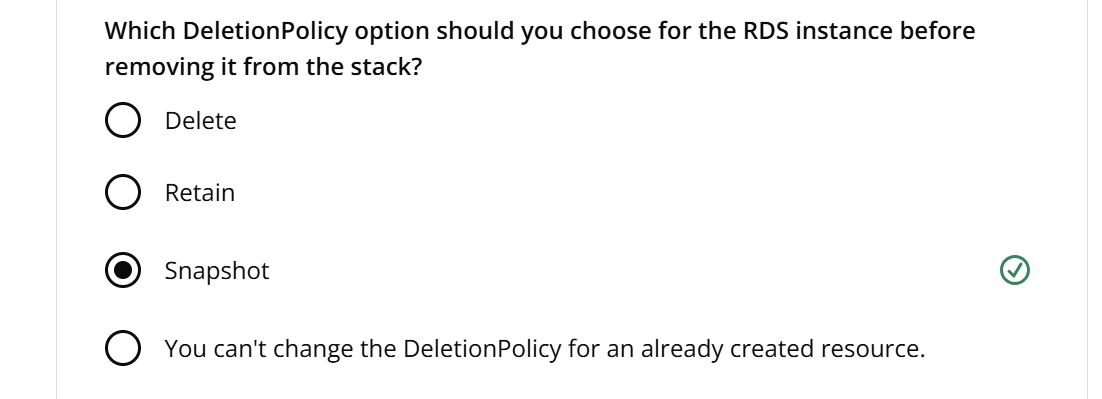

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-attribute-deletionpolicy.html

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_DeleteInstance.html

## Exercise: MySQL Database for MyWebAPP

You are tasked with creating a MySQL database for the MyWebApp application. The database must be RDS managed, and all resources are handled with CloudFormation. Important information will be stored in this database, so it must be protected against accidental deletion or data loss. Also, the development team has given you specific properties to set for the engine.

Exercise Prompt
Create a CloudFormation template with the required RDS resources, considering:

Create the network stack using the starter template provided for this exercise.
The network stack exports VPC and subnet parameters. Import them in your solution template.
The database engine must be MySQL 8.0.32 or newer.
Use a db.t3.micro instance class.
Allocate 20 GiB to the instance.
Protect your database against accidental data loss.
Place your database in the private subnets.
Pass your master username and password as parameters. The values must be specified only in a JSON parameters file.
The database security group should allow access on port 3306 for the CIDR block 10.10.0.0/24
The engine must be configured with the following parameters:
innodb_buffer_pool_instances: 1
innodb_buffer_pool_size: 134217728
max_connections: 1000
IMPORTANT

This exercise solution includes RDS instances. Although db.t3.micro instances are included in the free tier plan, if you no longer have that plan available or kept RDS instances running for a long time, you might have associated hourly charges. Remember to delete your stack after completion.


To correctly delete your RDS instance, remove deletion protection.

aws cloudformation create-stack --stack-name rds-database \
    --template-bodyrds-example.yml \\
    --paramete=rds-example.json \  \
    --region=us-east-1

## Solution: MySQL Database for MyWebAPP

https://www.youtube.com/watch?v=VdWvjDKoDrw

## RDS and S3 Use Cases

https://www.youtube.com/watch?v=MOUEt0QOnJk

Use file stores instead of databases for static media files, such as videos, images, and text documents.

Configuration files and sensitive encrypted data are best stored in specific file stores rather than inside the servers. Autoscaling groups may create or destroy servers, so keep data that you want to persist in separate resources such as a file store.

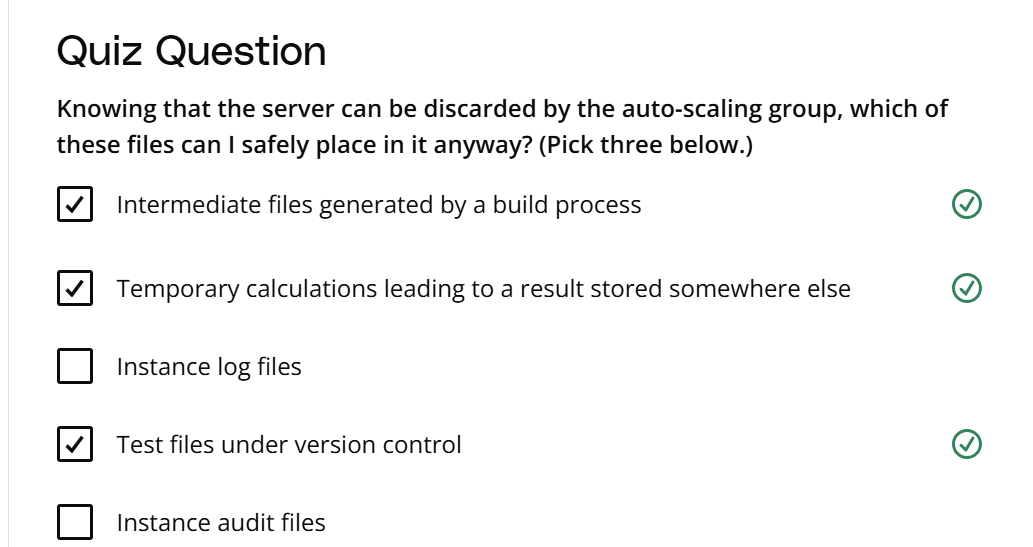

## S3 Buckets

The quintessential AWS service for storing these type of files is Amazon S3, and its insignia resource: the S3 bucket. We've introduced it before, and now that you know better when to use it, let's learn how to create it using CloudFormation.

## Adding S3 Buckets to Our Template

AWS::S3::Bucket Syntax
This is how you would add an S3 bucket to your CloudFormation template.

Resources:
  MyBucket:
    Type: 'AWS::S3::Bucket'
    Properties:
      BucketName: String
      AccessControl: String
      VersioningConfiguration:
        Status: String
      BucketEncryption:
        ServerSideEncryptionConfiguration:
          - ServerSideEncryptionByDefault:
              SSEAlgorithm: String
      LifecycleConfiguration:
        Rules:
          - ExpirationInDays: Integer
            Status: String
            NoncurrentVersionExpirationInDays: Integer
      PublicAccessBlockConfiguration:
        BlockPublicAcls: Boolean
        IgnorePublicAcls: Boolean
        BlockPublicPolicy: Boolean
        RestrictPublicBuckets: Boolean

BucketName: The name of the S3 bucket to be created. This name must be unique across all existing bucket names in Amazon S3 (not just your account!).
AccessControl: The access control list (ACL) that determines who can access the bucket and its contents. Valid values are Private, PublicRead, PublicReadWrite, AuthenticatedRead, LogDeliveryWrite, and BucketOwnerRead. Best practice: always use private access control and grant specific access to files using IAM roles, unless strictly necessary.
VersioningConfiguration: Specifies whether versioning is enabled for the bucket and the versioning status. With versioning, older versions of your files are kept in your bucket instead of deleted.
BucketEncryption: Specifies the server-side encryption settings for the bucket. You can use AWS key management service (KMS) or a transparent S3 encryption using AES256.
LifecycleConfiguration: This property includes rules that specify when objects expire and what actions to take when they do.
PublicAccessBlockConfiguration: A very important property, as it can protect against accidental exposure of private files in a bucket. It provides four blocking policies enforcing private access to your files.
There are several other properties that are interesting to review, and will probably be necessary for many use cases in your professional DevOps career, so be sure to take a look at the resource reference in the Additional resources section.

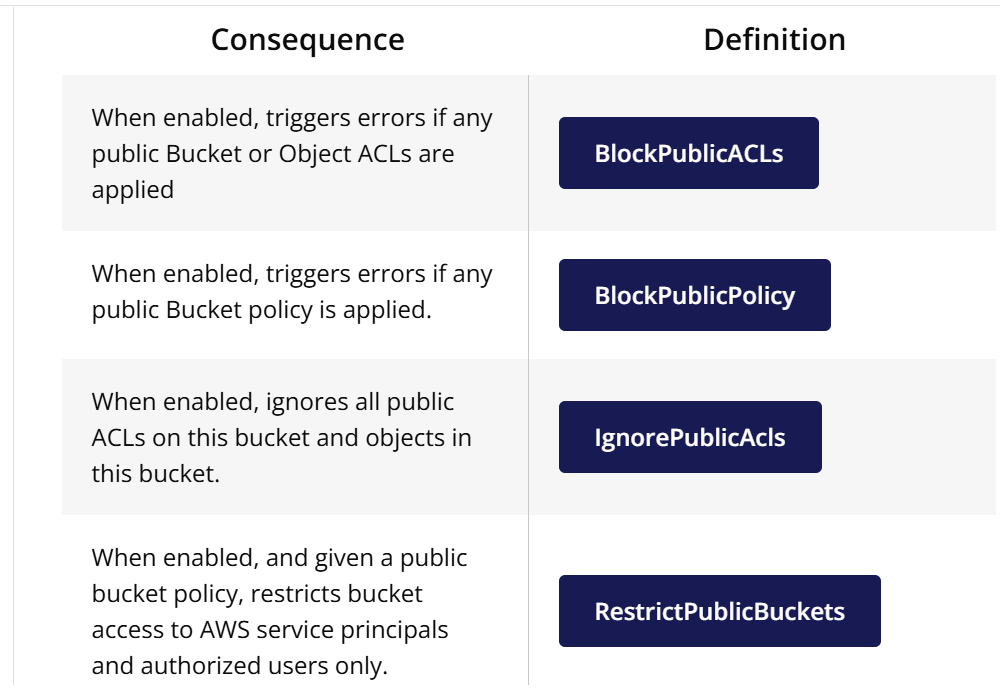

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-s3-bucket.html

## Exercise: Granting Access to S3 buckets

You now understand how to add S3 buckets to your CloudFormation. But do you remember how to grant access to those buckets from your EC2 instances?

In this exercise, you will adjust the provided CloudFormation template to grant access to an S3 bucket from a group of EC2 servers. Of course, you will need to create the bucket itself.

Exercise Prompt
A starter CloudFormation template is provided in the GitHub repository folder. Make the following adjustments:

Add an S3 bucket to the template. Name it as you like.
Make sure that all content in the bucket is and remains private.
Enable Versioning for the bucket.
Enable S3 AES256 encryption for the bucket.
Create the required IAM resources for granting s3:GetObject and s3:PutObject permissions to the S3 bucket (IAM InstanceProfile and IAM Role).
Modify the Launch Template so the instances can assume the created role.
Remember to use the proper CloudFormation capabilities when creating the IAM resources using the CLI.
IMPORTANT

This exercise solution includes EC2 instances. Although t2.micro is included in the free tier plan, you might have associated hourly charges if you no longer have that plan available or keep EC2 instances running for a long time. Remember to delete your stack after completion.

## Solution: Granting Access to S3 buckets

https://www.youtube.com/watch?v=OkvTLwlVSXc

## Previewing Deployments with CloudFormation Change Sets

By now you should be feeling comfortable creating resources in a CloudFormation template. We've studied several important resources that will absolutely appear in your Cloud DevOps career. We have also learned some useful CloudFormation internals, like intrinsic functions and common attribute resources.

We are close to finishing this course and lesson, but we also want to give you a couple of last tricks you can add to your skill set, improving your usage of the CloudFormation CLI and automatization scripting.

https://www.youtube.com/watch?v=NzXQIvnRSsQ

A CloudFormation change set is a summary of changes that will be made to a stack before you execute them. The workflow is the following:

Modify a template.
Instead of deploying the new template, create a change set resource.
Describe the change set resource to understand what modifications will be applied.
Create additional change sets if you need to make adjustments.
Apply the change set you desire so CloudFormation will try and update the relevant resources.
Let's see them in action. Consider the following template called vpc.yml:

In [ ]:
Resources:
  VPC: 
    Type: AWS::EC2::VPC
    Properties:
      CidrBlock: 10.15.0.0/16
      EnableDnsHostnames: true
  PublicSubnet: 
    Type: AWS::EC2::Subnet
    Properties:
      VpcId: !Ref VPC
      AvailabilityZone: !Select [ 0, !GetAZs '' ]
      CidrBlock: 10.15.0.0/24
      MapPublicIpOnLaunch: true

Let's deploy it into a stack using the create-stack command:

After correctly deploying the service, we notice we forgot to add tags! So we add them to the template. We could edit the same template file, but let's say we create a new one called vpc-tagged.yml:

In [ ]:
Resources:
  VPC: 
    Type: AWS::EC2::VPC
    Properties:
      CidrBlock: 10.15.0.0/16
      EnableDnsHostnames: true
      Tags: 
      - Key: Name 
        Value: udacity-my-vpc
  PublicSubnet: 
    Type: AWS::EC2::Subnet
    Properties:
      VpcId: !Ref VPC
      AvailabilityZone: !Select [ 0, !GetAZs '' ]
      CidrBlock: 10.15.0.0/24
      MapPublicIpOnLaunch: true
      Tags: 
      - Key: Name 
        Value: udacity-my-subnet

If we trigger the create-stack command, tags will be added. But imagine this template change was introduced by a colleague in your DevOps team. And since you're the one applying it, you will feel safe confirming that the change to be implemented is the one you expect. So you start by creating a change set using the CLI:

After a little while, the change set is created, and we can review the upcoming changes like this:

aws cloudformation describe-change-set --stack-name cd12352-lesson-changesets --change-set-name tagging-resources --region us-east-1

This command returns a JSON showing several properties specific to the change set resource, including the changes to implement:m

In [ ]:

{
    "Changes": [
        {
            "Type": "Resource",
            "ResourceChange": {
                "Action": "Modify",
                "LogicalResourceId": "PublicSubnet",
                "PhysicalResourceId": "subnet-0d76b52b1c58da746",
                "ResourceType": "AWS::EC2::Subnet",
                "Replacement": "False",
                "Scope": [
                    "Properties"
                ],
                "Details": [
                    {
                        "Target": {
                            "Attribute": "Properties",
                            "Name": "Tags",
                            "RequiresRecreation": "Never"
                        },
                        "Evaluation": "Static",
                        "ChangeSource": "DirectModification"
                    }
                ]
            }
        },
        {
            "Type": "Resource",
            "ResourceChange": {
                "Action": "Modify",
                "LogicalResourceId": "VPC",
                "PhysicalResourceId": "vpc-0e86f71fb4810a255",
                "ResourceType": "AWS::EC2::VPC",
                "Replacement": "False",
                "Scope": [
                    "Properties"
                ],
                "Details": [
                    {
                        "Target": {
                            "Attribute": "Properties",
                            "Name": "Tags",
                            "RequiresRecreation": "Never"
                        },
                        "Evaluation": "Static",
                        "ChangeSource": "DirectModification"
                    }
                ]
            }
        }
    ],
    ...
}

There you can see two upcoming modifications ("Action": "Modify") to the resources stated in the LogicalResourceId fields. You can also see in the Details key the Target of the modifications: in both cases, the Tags properties. Now you can proceed and apply the change set:

## Adding and Deleting Change Sets
If you're not satisfied with the changes, you can adjust your template, add new change sets to your stack, and review them as many times as needed.

It's important to notice that after executing your change set, CloudFormation deletes any additional change sets in your stack And of course, change sets can also be deleted using the CLI:

aws cloudformation delete-change-set --stack-name cd12352-lesson-changesets --change-set-name tagging-resources --region us-east-1

## Change sets and the deploy command
Notice that the deploy command we've presented previously is in fact a wrapper for the change set workflow. That is, whenever you run aws cloudformation deploy, CloudFormation will actually create and apply a change set behind the scenes.

In particular, if you add the --no-execute-changeset to your deploy command, the create set will be created, but it won't be executed. Take a look at this example

aws cloudformation deploy \
   --stack-name cd12352-lesson-changesets \
   --template-file vpc.yml \
   --no-execute-changeset \
    --region us-east-1

Waiting for changeset to be created..
Changeset created successfully. Run the following command to review changes:
aws cloudformation describe-change-set --change-set-name arn:aws:cloudformation:us-east-1:0123456789:changeSet/awscli-cloudformation-package-deploy-1679323545/349fec06-70d3-465d-b468-55d3f3616ad9

As you can see, after executing the command it even gives you the describe-change-set command to execute and review the change set.

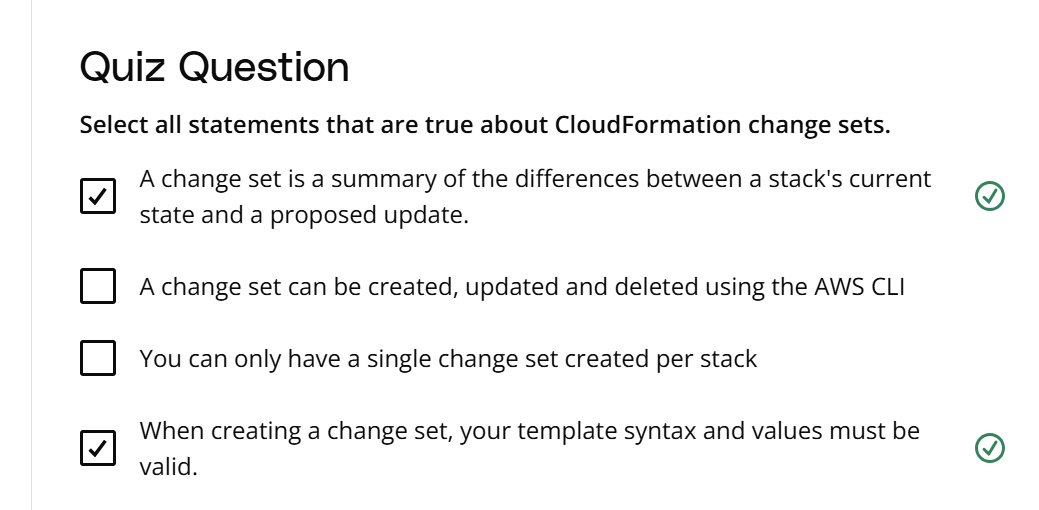

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/using-cfn-updating-stacks-changesets.html

https://awscli.amazonaws.com/v2/documentation/api/latest/reference/cloudformation/create-change-set.html

https://awscli.amazonaws.com/v2/documentation/api/latest/reference/cloudformation/describe-change-set.html

https://awscli.amazonaws.com/v2/documentation/api/latest/reference/cloudformation/delete-change-set.html

## Adding Parameters to your IAC scripts

As we've discussed before, your CloudFormation templates should be treated as code, by keeping them under version control tools and have their workflows automated as much as possible. We have already used a few simple scripts for creating and updating stacks.

In this section, we will see an example of how to parameterize these scripts for automating your Infrastructure as Code deployments and previews.

Creating a single script for deployment
We will leverage the deploy command, as we have seen it gives us a few advantages over the create-stack and update-stack commands:

Automatically detects when to create or update stacks
Can be executed synchronously
Uses change sets, allowing us to preview our changes beforehand.
We will use bash in our example. Keep in mind that this can be achieved with any scripting language, so don't worry too much about syntax if you're not familiar with it. The important takeaway here is to understand the underlying principles and importance of automating your IAC workflows.

Our goal is to create a single script allowing the creation, update, and deletion of stacks. We also want to be able to have a preview mode, by creating change sets and reviewing them before applying.

Our first parameter ($1) will be execution mode. Our expected values are deploy, delete, and preview. Let's call our script run.sh and start by documenting and validating these parameters:

#!/bin/bash
# Automation script for CloudFormation templates. 
#
# Parameters
#   $1: Execution mode. Valid values: deploy, delete, preview.
#
# Usage examples:
#   ./run.sh deploy 
#   ./run.sh preview
#   ./run.sh delete
#

# Validate parameters
if [[ $1 != "deploy" && $1 != "delete" && $1 != "preview" ]]; then
    echo "ERROR: Incorrect execution mode. Valid values: deploy, delete, preview." >&2
    exit 1
fi

The first block of this code is healthy documentation. We then start the actual code with an if block: we check if the value of our first argument ($1) is equal to any of our allowed values. If this isn't so, we print an error message using echo and end the execution with exit. We then close the conditional block with fi.

In the following example, we used a wrong parameter and get an error:

./run.sh wrong_value
ERROR: Incorrect execution mode. Valid values: deploy, delete, preview.

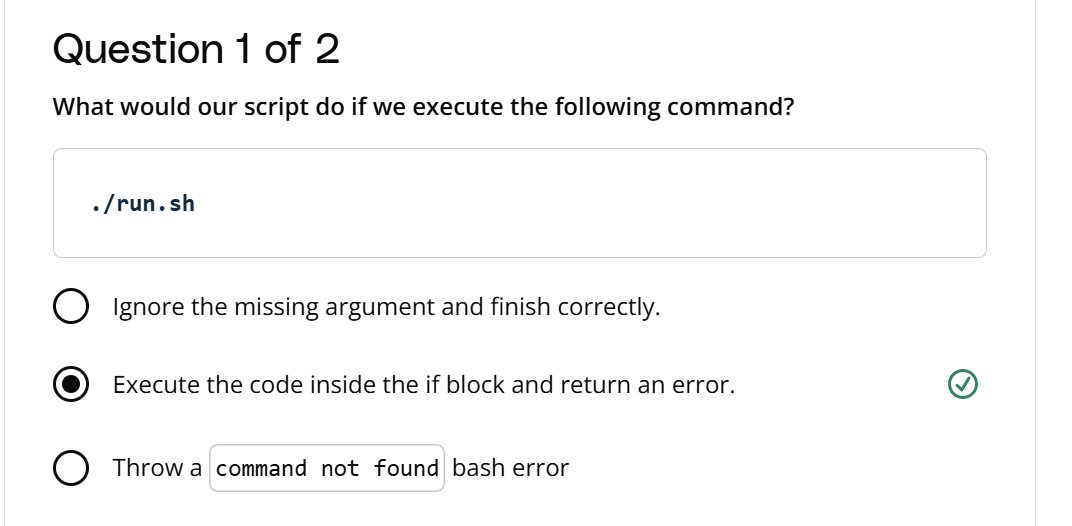

Let's continue our script. Since we have confirmed our first parameter to be correct, we can add more code and condition the script execution accordingly using if blocks. First, if the $1 value is deploy, we execute a deploy command.

In [ ]:
if [ $1 == "deploy" ]
then
    aws cloudformation deploy \
        --stack-name d12352-lesson5-parameter-scripts \
        --template-file vpc.yml
fi

In the same manner, we can implement the delete or preview condition blocks. For example, let's add this block right beneath our deploy condition:

In [ ]:
if [ $1 == "preview" ]
then
    aws cloudformation deploy \
        --stack-name d12352-lesson5-parameter-scripts \
        --template-file vpc.yml \
        --no-execute-changeset
fi

Not that complicated, isn't it? This is a very simple version of an automation script. However, as you probably already noticed, there are several optimizations that can be applied to this script. We will try to improve it in the upcoming exercise.

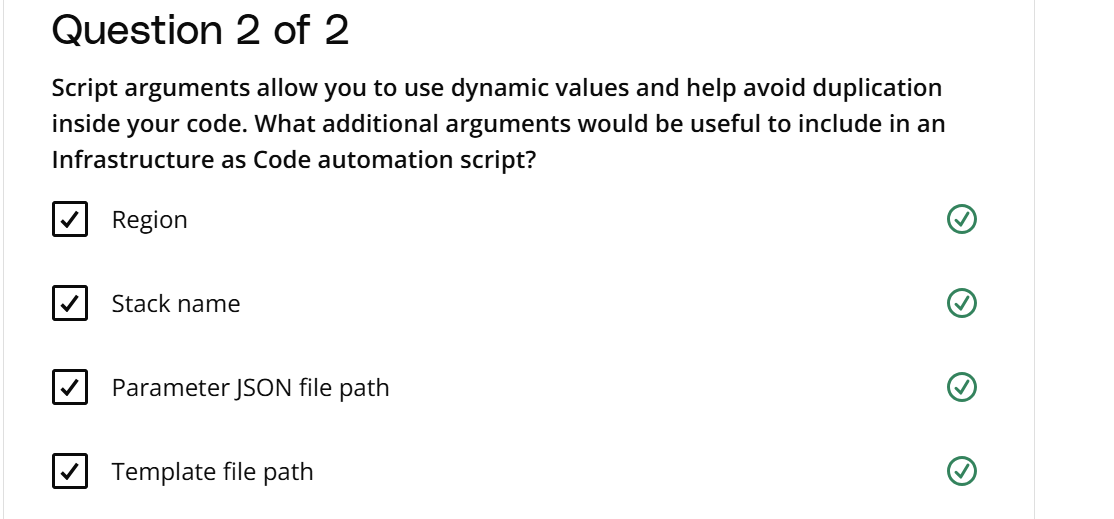

## Exercise: CloudFormation Deployment Pipeline

During this week's sprint planning meeting, you were assigned the critical task of creating a unified automation script, that could be used across all the Infrastructure as Code deployment pipelines of your team.

Your deployment pipelines are Linux based, so you are asked to create your script using bash.

Exercise Prompt
Create a bash script to execute CloudFormation CLI commands, with the following arguments:

An execution mode argument for executing either a deploy, delete or preview workflow. The script must validate it receives accepted values for this argument.
The target AWS region.
The name of the target CloudFormation stack.
The name of your template file (optional parameter).
The name of your parameters file (optional parameter).

## Solution: CloudFormation Deployment Pipeline

https://www.youtube.com/watch?v=OHixRC0x1KY

## Conclusion

https://www.youtube.com/watch?v=zxybfrpfcuo

As this last lesson comes to an end, you should now be able to:

Deploy highly available RDS databases using CloudFormation.
Configure secure S3 buckets using CloudFormation.
Preview changes to your CloudFormation stacks using change sets.
Automate your infrastructure workflows using parameterized scripts.
Congratulations on finishing the contents of this course! Now it's time for you to put your new skills to use by completing this course project. Give it your best!

## Bringing it all Together

https://www.youtube.com/watch?v=3Bt1u5N60m0

If you've been following the lessons up until now, you should already have an idea of what you can do with CloudFormation, although the big picture may still be a bit vague. That's alright, though; in the course project, you are going to put what you've learned into practice. The next few pages are put together to better prepare you for completing it.

By the end of these lessons, you should...
Understand how everything you've learned so far fits together in web application development.
Understand what is needed to create a single page static website.
Be able to debug a published infrastructure. This is very important as it is a significant part of what you will do.
But first, let's try to understand the big picture.

The Big Picture
Take a look at the solution code in the lesson Servers and Security Groups, page Solution: Load Balancing WebApp Servers. We will use the infrastructure produced by that template as a base.

What happens when an HTTP request (on port 80) lands on your server?

Load Balancer Receives the Request:
The Application Load Balancer (ALB) Listener is going to be the first component in your infrastructure that "listens" to that request.
Routing Decision by ALB:
The ALB evaluates the request against the listener rules defined by the ListenerRule component.
Since the setup has a rule for forwarding traffic coming to path /, the ALB forwards the request to the TargetGroup.
Target Group Processing:
The TargetGroup determines which instances in the Auto Scaling group (AutoScalingGroup) should handle the request.
The TargetGroup uses health checks defined in it to ensure that it forwards the request to a healthy instance.
Request Reaches the EC2 Instance:
The selected EC2 instance, part of the AutoScalingGroup, receives the request. This instance is configured with the LaunchTemplate.
IMPORTANT: Notice that the LaunchTemplate has an ImageId property. You need to set it up with an AMI of a new Ubuntu instance. Look for an appropriate AMI in your AWS EC2 console, and then find a link to the AMI Catalog from the left sidebar.
The AutoScalingGroup will spin up additional instances when needed and drop unused extra instances but will keep a minimum of MinSize instances. It means the EC2 instances created in the infrastructure are ephemeral; they do not keep their states. This fact will be important later when you need to debug your EC2 instances.
Response Sent Back:
The response from the EC2 instance (either static content or dynamically generated content) is sent back to the ALB.
The ALB then routes this response back to the client who initiated the request.

## Web Server

What About a Web Server?

https://www.youtube.com/watch?v=b6jAVASC374

If you want the EC2 instances spun up by AutoScalingGroup to act as a web server, you will need to set them up as one. You can do this by configuring them to install and set up a web server when they are first instantiated. Remember that in Servers and Security Groups > Launch Templates we talked about the LaunchTemplateData.UserData property. You may enter a setup script into it.

Before that, though, please don't forget to set the ImageId property to the latest Ubuntu AMI, else the webserver won't run.

In the project, you will be given a starter code to install and start your NGINX server:

In [ ]:
#!/bin/bash
apt-get update -y
sudo apt-get install nginx -y
service nginx start

When set up properly, you should see the following page when accessing your LoadBalancer's public URL:

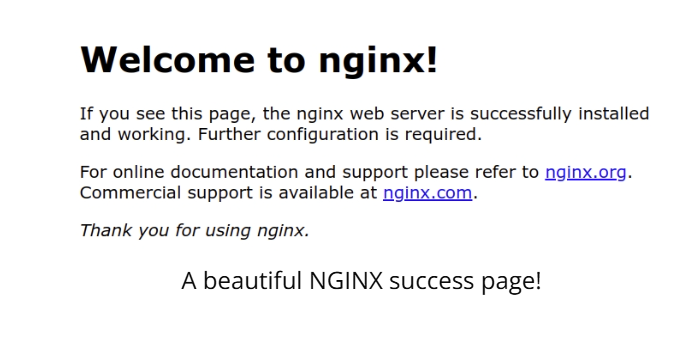

Wait, What is a "LoadBalancer's Public URL"?
Remember from the previous page that the LoadBalancer is the first component to receive a user's request. The request is sent to the LoadBalancer's Domain Name Server (DNS), which also serves as the public URL accessible via a browser.

Troubleshooting: I got a 502 error instead!
A 502 error indicates that NGINX was not found on the server. There are two most common problems:

The most likely cause of this is when we don't use the right AMI for our EC2 instances. Please make sure to pick a UBUNTU AMI that is available in your AWS region.
By default, NGINX web server is accessible from port 80, so make sure to open this port for inbound connections. Alternatively, you may also update the NGINX starting code so it runs on port 3000.
If that wasn't the case or you got a different error, you'll need to debug your completed infrastructure, which will be covered in the next few pages.

https://www.youtube.com/watch?v=LtQJEK04ldk

Updating Your Website's Index Page
One of the project's rubric requirements is to display a page that contains the following text:

it works! Udagram, Udacity
Therefore, you'll need to update your index page from the original NGINX welcome page shown above.

To do this, the LaunchTemplateData.UserData property can be updated to include a script that does the following:

Create a new index.html file.
Save this file in the /var/www/html/ directory. This directory has another file, index.nginx-debian.html, which is the default page you saw earlier. The index.html page you add will take precedence over this page.
Reload nginx.
Here are some useful bash commands to help you achieve this:

To Store Text into a File
cat <<EOF > [filename]
[content]
EOF
Replace [filename] with a filename and [content] with the content to be saved into that file.

To Copy or Move a File
cp [old location] [new location]
mv [old location] [new location]
To Act as a Root User
The /var/www/html/ directory is restricted, so you'll need root access to edit it.

You can add sudo to run these commands as a root user, e.g., sudo cp index.html /var/www/html/index.html.

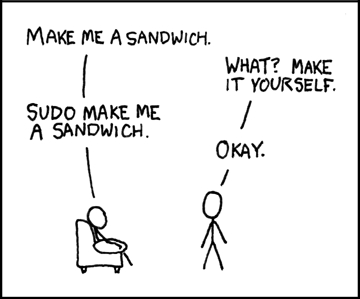

To Reload nginx
At the end of your script, add the following code to reload nginx to ensure the changes are propagated.

sudo systemctl reload nginx

https://www.youtube.com/watch?v=Ky5LBC-aus0

Static Assets

A website would be rather bland without any images, CSS, and possibly JavaScript. In the Storage and Databases lesson, you learned how to create an S3 bucket and grant your EC2 instances access to it. Revisit the pages from that lesson and add relevant code to your CloudFormation template.

In a real-world web application, server-related code is stored in EC2 instances while assets are stored in S3 buckets.

At the end of this step, your CloudFormation template should have the following components:

In [ ]:
 LaunchTemplate:
    Type: AWS::EC2::LaunchTemplate
    Properties: 
      LaunchTemplateData:
        UserData:
          # Fn::Base64: !Sub |
          Fn::Base64: |
            #!/bin/bash
            apt-get update -y
            sudo apt-get install nginx -y
            service nginx start

            # Script to create index.html
            ...

        ImageId: # Paste the latest UBUNTU AMI
        InstanceType: t2.micro # Replace this with t3.small or better to meet the rubric
        BlockDeviceMappings:
        - DeviceName: "/dev/sdk"
          Ebs:
            VolumeSize: 10

        # The following property is added to give the instances access
        # to read data from your S3 bucket.
        IamInstanceProfile:
          Name: !Ref InstanceRole

  # The S3 bucket
  S3Bucket:
    Type: AWS::S3::Bucket
    ...

  # Role and profile to read data from S3Bucket (and write if needed) 
  InstanceRole:
    Type: AWS::IAM::Role
    # There are some other settings here, check the lesson for details
    ...
    Policies:
    - PolicyName: s3
    PolicyDocument:
    Version: '2012-10-17'
    Statement:
    - Effect: Allow
      Action:
      - 's3:PutObject'
      - 's3:GetObject'
      Resource:
      - !GetAtt S3Bucket.Arn

  InstanceProfile:
    Type: AWS::IAM::InstanceProfile
    Properties:
      Path: '/'
      Roles:
      - !Ref InstanceRole
The rest of the template that isn't shown here is similar to the template from Servers and Security Groups > Solution: Load Balancing WebApp Servers

ssh -A -i ./MyKeyPair.pem ubuntu@54.242.209.50

In [ ]:
ssh ubuntu@10.2.3.69